In [ ]:
# -----------------------------
# Image Stitching Using Correlation & Weighted Blend
# -----------------------------

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d

# -----------------------------
# Utility Functions
# -----------------------------

def show(img, title="", cmap="gray"):
    plt.figure(figsize=(8, 4))
    plt.imshow(img, cmap=cmap, aspect="auto")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_pair(a, b, title1="Image 1", title2="Image 2", cmap="gray"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(a, cmap=cmap, aspect="auto"); ax[0].set_title(title1); ax[0].axis("off")
    ax[1].imshow(b, cmap=cmap, aspect="auto"); ax[1].set_title(title2); ax[1].axis("off")
    fig.tight_layout()
    plt.show()

def preprocess_for_corr(img: np.ndarray) -> np.ndarray:
    """Normalize and emphasize horizontal edges for correlation"""
    x = img.astype(np.float32)
    x -= x.mean()
    x /= (x.std() + 1e-9)
    x = np.abs(np.gradient(x, axis=1))  # horizontal edges
    return x

def crop_depth_band(img: np.ndarray, y0: int, y1: int) -> np.ndarray:
    """Keep only rows y0:y1 for correlation"""
    return img[y0:y1, :]

# -----------------------------
# Correlation Function
# -----------------------------

def corr_curve_shift_x(img1: np.ndarray, img2: np.ndarray, dx_min: int, dx_max: int):
    """Compute normalized, smoothed correlation curve over dx range"""
    a = preprocess_for_corr(img1)
    b = preprocess_for_corr(img2)

    h, w1 = a.shape
    _, w2 = b.shape

    dxs = np.arange(dx_min, dx_max + 1)
    scores = np.full(dxs.shape, -np.inf, dtype=np.float32)

    for t, dx in enumerate(dxs):
        ov_start = max(0, dx)
        ov_end = min(w1, dx + w2)
        if ov_end <= ov_start:
            continue
        a_ov = a[:, ov_start:ov_end]
        b_ov = b[:, (ov_start - dx):(ov_end - dx)]
        scores[t] = np.sum(a_ov * b_ov) / a_ov.size

    # Normalize 0..1
    finite = np.isfinite(scores)
    s = scores[finite]
    if s.size == 0:
        corr01 = scores
    else:
        mn, mx = float(s.min()), float(s.max())
        corr01 = (scores - mn) / (mx - mn + 1e-12)

    # Smooth correlation curve
    corr01_smooth = gaussian_filter1d(corr01, sigma=3)
    return dxs, corr01_smooth

# -----------------------------
# Stitching & Blending
# -----------------------------

def stitch_canvas(img1: np.ndarray, img2: np.ndarray, dx: int):
    """Place two images on a single canvas according to dx"""
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    if h1 != h2:
        raise ValueError("Images must have the same height.")

    # Full canvas size
    x_min = min(0, dx)
    x_max = max(w1, dx + w2)
    W = x_max - x_min
    H = h1

    x1 = -x_min
    x2 = dx - x_min

    c1 = np.zeros((H, W), dtype=np.float32)
    c2 = np.zeros((H, W), dtype=np.float32)
    c1[:, x1:x1+w1] = img1.astype(np.float32)
    c2[:, x2:x2+w2] = img2.astype(np.float32)

    return c1, c2, x1, x2, W, H

def combine_weighted_blend(img1: np.ndarray, img2: np.ndarray, dx: int):
    """Blend two images using one seamless linear ramp in the overlap"""
    c1, c2, x1, x2, W, H = stitch_canvas(img1, img2, dx)

    ov_start = max(x1, x2)
    ov_end   = min(x1 + img1.shape[1], x2 + img2.shape[1])
    overlap  = max(0, ov_end - ov_start)

    out = np.zeros((H, W), dtype=np.float32)
    out[:, :ov_start] = c1[:, :ov_start]

    if overlap > 0:
        ramp = np.linspace(0, 1, overlap)[None, :]
        out[:, ov_start:ov_end] = (1 - ramp) * c1[:, ov_start:ov_end] + ramp * c2[:, ov_start:ov_end]

    out[:, ov_end:] = c2[:, ov_end:]
    return out

# -----------------------------
# Main Stitch Function
# -----------------------------

def stitch_two_images(path1, path2,
                      search_margin_px=300,
                      depth_band=(150, 500),
                      show_steps=True):
    """Load, align, and stitch two images using correlation + weighted blend"""
    # Load images (grayscale)
    img1 = np.array(Image.open(path1).convert("L"), dtype=np.float32)
    img2 = np.array(Image.open(path2).convert("L"), dtype=np.float32)

    # Match heights
    H = min(img1.shape[0], img2.shape[0])
    img1 = img1[:H, :]
    img2 = img2[:H, :]

    if show_steps:
        show_pair(img1, img2, "Original Image 1", "Original Image 2")

    # Crop depth band for correlation
    y0, y1 = depth_band
    img1_corr = crop_depth_band(img1, y0, y1)
    img2_corr = crop_depth_band(img2, y0, y1)

    if show_steps:
        show_pair(img1_corr, img2_corr,
                  "Correlation Band Image 1",
                  "Correlation Band Image 2")

    # Compute dx search range
    dx_min = max(-img2_corr.shape[1] + 1, -search_margin_px)
    dx_max = min(img1_corr.shape[1] - 1, search_margin_px)

    dxs, corr01_smooth = corr_curve_shift_x(img1_corr, img2_corr, dx_min, dx_max)
    best_dx = int(dxs[np.argmax(corr01_smooth)])
    print(f"Best dx for stitching: {best_dx}")

    if show_steps:
        plt.figure(figsize=(8, 4))
        plt.plot(dxs, corr01_smooth, label='Smoothed Correlation')
        plt.axvline(best_dx, linestyle="--", color="red")
        plt.title("Correlation vs dx (cropped images)")
        plt.xlabel("dx (pixels)")
        plt.ylabel("Normalized correlation")
        plt.legend()
        plt.show()

    # Stitch full images
    stitched = combine_weighted_blend(img1, img2, best_dx)

    if show_steps:
        show(stitched, f"Stitched Image (dx={best_dx})")

    return img1, img2, stitched

# -----------------------------
# Example Usage
# -----------------------------

base_dir = "/Users/ottobruce-gardyne/Documents/Year 4/GIP/signal-processing-G2066/1D TFM Data/Al Hole 5MHz 26012026"
path1 = os.path.join(base_dir, "Al_40_5_TFM_clean.png")
path2 = os.path.join(base_dir, "Al_40_6_TFM_clean.png")

print("Path 1 exists:", os.path.exists(path1))
print("Path 2 exists:", os.path.exists(path2))

img1, img2, stitched = stitch_two_images(path1, path2,
                                         search_margin_px=300,
                                         depth_band=(150, 500),
                                         show_steps=True)


: 

Path 1 exists: True
Path 2 exists: True


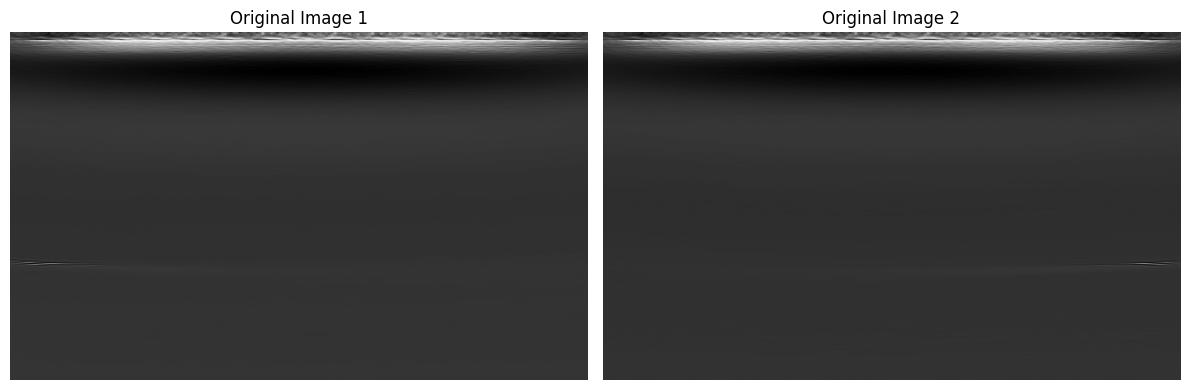

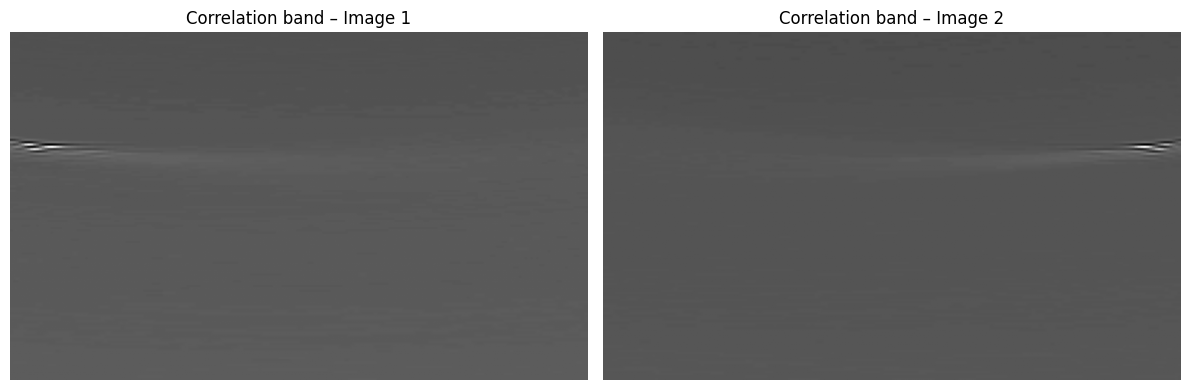

Best dx: -188
Peak correlation: 1.000


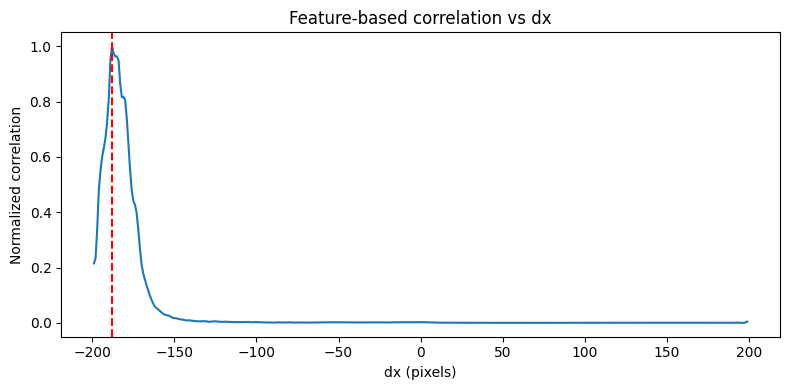

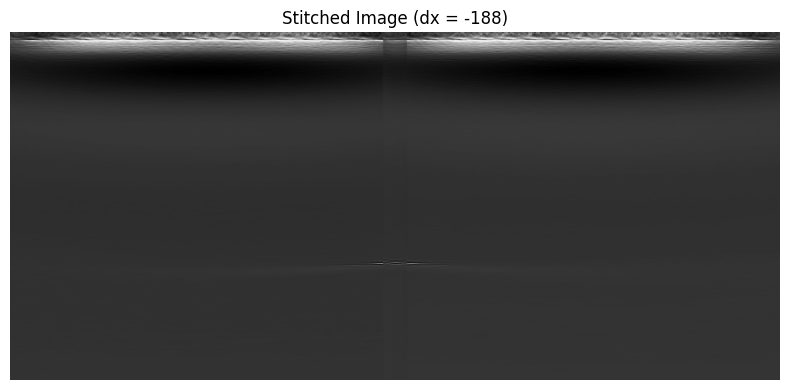

In [38]:
# -----------------------------
# Image Stitching Using Feature-Based Correlation & Weighted Blend
# -----------------------------

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------
# Utility Functions
# -----------------------------

def show(img, title="", cmap="gray"):
    plt.figure(figsize=(8, 4))
    plt.imshow(img, cmap=cmap, aspect="auto")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_pair(a, b, title1="Image 1", title2="Image 2", cmap="gray"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(a, cmap=cmap, aspect="auto")
    ax[0].set_title(title1)
    ax[0].axis("off")
    ax[1].imshow(b, cmap=cmap, aspect="auto")
    ax[1].set_title(title2)
    ax[1].axis("off")
    fig.tight_layout()
    plt.show()

# -----------------------------
# Preprocessing for Correlation
# -----------------------------

def preprocess_for_corr(img: np.ndarray) -> np.ndarray:
    """
    Feature-based preprocessing:
    - normalize
    - emphasize horizontal structure (x-gradient)
    """
    x = img.astype(np.float32)
    x -= x.mean()
    x /= (x.std() + 1e-9)

    # Emphasize reflectors / vertical features
    x = np.abs(np.gradient(x, axis=1))
    return x

def crop_depth_band(img: np.ndarray, y0: int, y1: int) -> np.ndarray:
    return img[y0:y1, :]

# -----------------------------
# Correlation Function
# -----------------------------

def corr_curve_shift_x(img1: np.ndarray,
                       img2: np.ndarray,
                       dx_min: int,
                       dx_max: int):

    a = preprocess_for_corr(img1)
    b = preprocess_for_corr(img2)

    h, w1 = a.shape
    _, w2 = b.shape

    dxs = np.arange(dx_min, dx_max + 1)
    scores = np.full(dxs.shape, -np.inf, dtype=np.float32)

    for t, dx in enumerate(dxs):
        ov_start = max(0, dx)
        ov_end   = min(w1, dx + w2)

        if ov_end <= ov_start:
            continue

        a_ov = a[:, ov_start:ov_end]
        b_ov = b[:, (ov_start - dx):(ov_end - dx)]

        # NORMALIZED correlation (critical)
        scores[t] = np.sum(a_ov * b_ov) / a_ov.size

    # Normalize to 0..1 for plotting
    finite = np.isfinite(scores)
    if np.any(finite):
        mn, mx = scores[finite].min(), scores[finite].max()
        corr01 = (scores - mn) / (mx - mn + 1e-12)
    else:
        corr01 = scores

    return dxs, corr01

# -----------------------------
# Stitching & Blending
# -----------------------------

def stitch_canvas(img1: np.ndarray, img2: np.ndarray, dx: int):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    if h1 != h2:
        raise ValueError("Images must have the same height")

    x_min = min(0, dx)
    x_max = max(w1, dx + w2)

    W = x_max - x_min
    H = h1

    x1 = -x_min
    x2 = dx - x_min

    c1 = np.zeros((H, W), dtype=np.float32)
    c2 = np.zeros((H, W), dtype=np.float32)

    c1[:, x1:x1 + w1] = img1
    c2[:, x2:x2 + w2] = img2

    return c1, c2, x1, x2

def combine_weighted_blend(img1: np.ndarray, img2: np.ndarray, dx: int):
    c1, c2, x1, x2 = stitch_canvas(img1, img2, dx)

    w1 = img1.shape[1]
    w2 = img2.shape[1]

    ov_start = max(x1, x2)
    ov_end   = min(x1 + w1, x2 + w2)
    overlap  = max(0, ov_end - ov_start)

    out = np.zeros_like(c1)
    out[:] = c1

    if overlap > 0:
        ramp = np.linspace(0, 1, overlap, endpoint=False)[None, :]
        img1_ov = img1[:, (ov_start - x1):(ov_end - x1)]
        img2_ov = img2[:, (ov_start - x2):(ov_end - x2)]

        out[:, ov_start:ov_end] = (1 - ramp) * img1_ov + ramp * img2_ov

    # Fill non-overlapping img2 region
    mask2 = (c2 != 0) & (out == 0)
    out[mask2] = c2[mask2]

    return out

# -----------------------------
# Main Stitch Function
# -----------------------------

def stitch_two_images(path1, path2,
                      search_margin_px=300,
                      depth_band=(150, 500),
                      show_steps=True):

    # Load images (grayscale intensity)
    img1 = np.array(Image.open(path1).convert("L"), dtype=np.float32)
    img2 = np.array(Image.open(path2).convert("L"), dtype=np.float32)

    # Match height
    H = min(img1.shape[0], img2.shape[0])
    img1 = img1[:H, :]
    img2 = img2[:H, :]

    if show_steps:
        show_pair(img1, img2, "Original Image 1", "Original Image 2")

    # ---- DEPTH BAND FOR CORRELATION ONLY ----
    y0, y1 = depth_band
    img1_corr = crop_depth_band(img1, y0, y1)
    img2_corr = crop_depth_band(img2, y0, y1)

    if show_steps:
        show_pair(img1_corr, img2_corr,
                  "Correlation band – Image 1",
                  "Correlation band – Image 2")

    dx_min = max(-img2_corr.shape[1] + 1, -search_margin_px)
    dx_max = min(img1_corr.shape[1] - 1, search_margin_px)

    dxs, corr01 = corr_curve_shift_x(img1_corr, img2_corr, dx_min, dx_max)

    best_dx = int(dxs[np.argmax(corr01)])
    print(f"Best dx: {best_dx}")
    print(f"Peak correlation: {corr01.max():.3f}")

    if show_steps:
        plt.figure(figsize=(8, 4))
        plt.plot(dxs, corr01)
        plt.axvline(best_dx, color="red", linestyle="--")
        plt.title("Feature-based correlation vs dx")
        plt.xlabel("dx (pixels)")
        plt.ylabel("Normalized correlation")
        plt.tight_layout()
        plt.show()

    # ---- STITCH FULL IMAGES ----
    stitched = combine_weighted_blend(img1, img2, best_dx)

    if show_steps:
        show(stitched, f"Stitched Image (dx = {best_dx})")

    return img1, img2, stitched

# -----------------------------
# Example Usage
# -----------------------------

base_dir = "/Users/ottobruce-gardyne/Documents/Year 4/GIP/signal-processing-G2066/1D TFM Data/Al Hole 15MHz 26012026"
path1 = os.path.join(base_dir, "Al_40_1_TFM_clean.png")
path2 = os.path.join(base_dir, "Al_40_2_TFM_clean.png")

print("Path 1 exists:", os.path.exists(path1))
print("Path 2 exists:", os.path.exists(path2))

img1, img2, stitched = stitch_two_images(
    path1,
    path2,
    search_margin_px=300,
    depth_band=(150, 500),
    show_steps=True
)
